# Context

From the set of images captured by the UAV, all those with occurrence of weeds were selected resulting a total of 400 images. Through the Pynovisão software, using the SLIC algorithm, these images were segmented and the segments annotated manually with their respective class. These segments were used in the construction of the image dataset.


This code helps to classify plant images into 4 different classes from a dataset of Soybean crops. Multi-class classification is done by training a convolutional neural network.

# Content

This image dataset has 15336 segments, being 3249 of soil, 7376 of soybean, 3520 grass and 1191 of broadleaf weeds. 




## Importing libraries 

In [8]:
# Dependencies
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from PIL import Image
import pandas as pd
from resizeimage import resizeimage
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
import pickle
import warnings
from os import listdir
from numpy import asarray
from numpy import array
from sklearn.preprocessing import LabelEncoder
# # Config
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.utils import to_categorical
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as  mpimg
import seaborn as sns
%matplotlib inline 

import os
np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools 

from keras.utils.np_utils import to_categorical 
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook',palette="deep")

#### Creating input directory and Categories for dependent variable

In [10]:
DATADIR = '/home/parikshit/Downloads/weed-detection-in-soybean-crops/dataset/dataset'
#DATADIR = '/home/parikshit/Downloads/weed-detection-in-soybean-crops/temp/datasets/dataset'

CATEGORIES = ['broadleaf', 'grass','soil','soybean']

In [11]:
training_data=[]

#### Importaing data 

In [12]:
training_data = []

def create_training_data():
    for category in CATEGORIES:  

        path = os.path.join(DATADIR,category)  
        class_num = CATEGORIES.index(category)  

        for img in tqdm(os.listdir(path)):  # iterate over each image 
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (120,120))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

100%|██████████| 7376/7376 [00:14<00:00, 521.05it/s]


In [13]:
X=[]
y=[]

In [14]:
for features,label in training_data:
    X.append(features)
    y.append(label)

#### Converting Images to numpy arrays

In [15]:
X = np.array(X).reshape(-1, 120,120,1)

We perform a grayscale normalization to reduce the effect of illumination's differences.
Moreover the CNN converg faster on [0..1] data than on [0..255].

In [16]:
X = X/255.0

#### Encoding the dependent variable

In [17]:
y = to_categorical(y, num_classes=4)

In [18]:
random_seed = 2

#### Creating training and testing data sets

In [19]:
X_train,X_val,Y_train,Y_val = train_test_split(X,y,test_size = 0.3, random_state= random_seed)

#### Augmenting images 

In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [27]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(X_train)

#### Training the convolutional neural network

The first is the convolutional (Conv2D) layer. It is like a set of learnable filters. I choosed to set 4 filters for the two firsts conv2D layers and 3 filters for the two last ones. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time) more the pooling dimension is high, more the downsampling is important.

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

In the end the features in two fully-connected (Dense) layers which is just artificial an neural networks (ANN) classifier are used. In the last layer(Dense(10,activation="softmax")) the net outputs distribution of probability of each class.

In [21]:
model = Sequential()

model.add(Conv2D(filters=4, kernel_size=(3,3), padding = "Same", activation='relu',input_shape=(120,120,1)))
model.add(Conv2D(filters=4, kernel_size=(3,3), padding = "Same", activation='relu',input_shape=(120,120,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters=3, kernel_size=(3,3), padding = "Same", activation='relu',input_shape=(120,120,1)))
model.add(Conv2D(filters=3, kernel_size=(3,3), padding = "Same", activation='relu',input_shape=(120,120,1)))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256,activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(4, activation = "softmax"))

# optimizer = RMSprop(lr = 0.001,rho = 0.9 , epsilon = 1e-08, decay = 0.0)
# model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ['accuracy'])
# model.fit(X_train, Y_train, batch_size=80, epochs=50, validation_split=0.3)

W1111 13:07:12.561669 140448332724032 deprecation_wrapper.py:119] From /home/parikshit/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1111 13:07:12.587258 140448332724032 deprecation_wrapper.py:119] From /home/parikshit/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1111 13:07:12.590387 140448332724032 deprecation_wrapper.py:119] From /home/parikshit/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1111 13:07:12.621195 140448332724032 deprecation_wrapper.py:119] From /home/parikshit/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d inste

Once our layers are added to the model, we need to set up a score function, a loss function and an optimisation algorithm.

The loss function is defined to measure how poorly our model performs on images with known labels. It is the error rate between the oberved labels and the predicted ones. A specific form for categorical classifications (>2 classes) called the "categorical_crossentropy" is used.

The most important function is the optimizer. This function will iteratively improve parameters (filters kernel values, weights and bias of neurons ...) in order to minimise the loss.

RMSprop (with default values) is used in this case, it is a very effective optimizer. The RMSProp update adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate. We could also have used Stochastic Gradient Descent ('sgd') optimizer, but it is slower than RMSprop.

The metric function "accuracy" is used is to evaluate the performance our model. This metric function is similar to the loss function, except that the results from the metric evaluation are not used when training the model (only for evaluation).

In [22]:
optimizer = RMSprop(lr = 0.001,rho = 0.9 , epsilon = 1e-08, decay = 0.0)

In [23]:
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ['accuracy'])

W1111 13:07:26.654920 140448332724032 deprecation_wrapper.py:119] From /home/parikshit/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1111 13:07:26.673025 140448332724032 deprecation_wrapper.py:119] From /home/parikshit/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

Its better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.

To keep the advantage of the fast computation time with a high LR, i decreased the LR dynamically every X steps (epochs) depending if it is necessary (when accuracy is not improved).

With the ReduceLROnPlateau function from Keras.callbacks, i choose to reduce the LR by half if the accuracy is not improved after 3 epochs.


In [24]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [25]:
epochs = 50 
batch_size = 80

In [121]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              ,callbacks=[learning_rate_reduction])

Epoch 1/50
 - 47s - loss: 1.1696 - acc: 0.4961 - val_loss: 1.2720 - val_acc: 0.3953
Epoch 2/50
 - 46s - loss: 1.0680 - acc: 0.5443 - val_loss: 1.1566 - val_acc: 0.5112
Epoch 3/50
 - 46s - loss: 1.0015 - acc: 0.5871 - val_loss: 1.0006 - val_acc: 0.6016
Epoch 4/50
 - 46s - loss: 0.9549 - acc: 0.6113 - val_loss: 1.1780 - val_acc: 0.4879
Epoch 5/50
 - 46s - loss: 0.9129 - acc: 0.6271 - val_loss: 1.0788 - val_acc: 0.5862
Epoch 6/50
 - 46s - loss: 0.8712 - acc: 0.6455 - val_loss: 0.8875 - val_acc: 0.6344
Epoch 7/50
 - 46s - loss: 0.8345 - acc: 0.6616 - val_loss: 0.9180 - val_acc: 0.6016
Epoch 8/50
 - 46s - loss: 0.8251 - acc: 0.6614 - val_loss: 0.9629 - val_acc: 0.6433
Epoch 9/50
 - 46s - loss: 0.8072 - acc: 0.6712 - val_loss: 0.8006 - val_acc: 0.6655
Epoch 10/50
 - 46s - loss: 0.7804 - acc: 0.6793 - val_loss: 0.7716 - val_acc: 0.6701
Epoch 11/50
 - 46s - loss: 0.7714 - acc: 0.6848 - val_loss: 0.9025 - val_acc: 0.6612
Epoch 12/50
 - 46s - loss: 0.7700 - acc: 0.6852 - val_loss: 0.7986 - val_a

#### Plotting the Loss and Accuracy for training and validation data sets

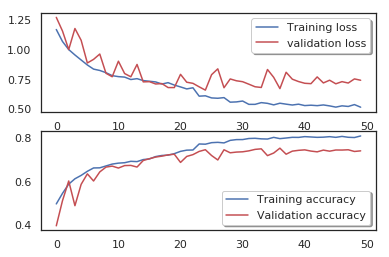

In [122]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

#### Plotting the confusion matrix

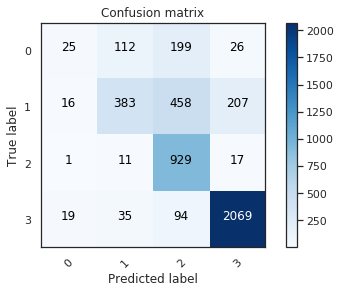

In [124]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(4)) 